In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''

In [4]:
import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from tqdm.std import trange
from sklearn import preprocessing
from torch.utils.data import dataloader
from pixelshuffle1d import PixelShuffle1D, PixelUnshuffle1D

In [7]:
preprocessing.normalize(np.array([1,2,3]).reshape(1,-1))

array([[0.26726124, 0.53452248, 0.80178373]])

## Generate data

$-\bigtriangledown\cdot  \left ( exp(\kappa ) \bigtriangledown u\left ( \textbf{x} \right )\right )=f\left ( \textbf{x} \right )$ 

$x\subseteq \left [ 0,1 \right ], y\subseteq \left [ 0,1 \right ]$ 

$f(x) = -(8π^2) * sin(2aπ(x+c)) * sin(2bπ(y+d))$

$a,b \in [0,2]; c,d \in [-2\pi,2\pi]$

$u(0,y)=u(1,y)=u(x,0)=u(x,1)=0$

In [33]:
def generate_data(N,a,b,c,d):
    h=1/N
    x=np.arange(0,1.0001,h)
    y=np.arange(0,1.0001,h)
    
    w=np.zeros((N+1,N+1))

    for j in range (0,N):
        w[0,j]=0 #Lower Boundary
        w[N,j]=0 #Upper Boundary
    
    N2=(N-1)*(N-1)
    A=np.zeros((N2,N2))
    ## Diagonal            
    for i in range (0,N-1):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j]=-4

    # LOWER DIAGONAL        
    for i in range (1,N-1):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j-1]=1   
    # UPPPER DIAGONAL        
    for i in range (0,N-2):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j+1]=1   

    # LOWER IDENTITY MATRIX
    for i in range (0,N-1):
        for j in range (1,N-1):           
            A[i+(N-1)*j,i+(N-1)*(j-1)]=1        
        
        
    # UPPER IDENTITY MATRIX
    for i in range (0,N-1):
        for j in range (0,N-2):           
            A[i+(N-1)*j,i+(N-1)*(j+1)]=1
    Ainv=np.linalg.inv(A) 
    
    r=np.zeros(N2)
    
    '''
    a = np.random.uniform(0,2)
    b = np.random.uniform(0,2)
    c = np.random.uniform(-2*np.pi,2*np.pi)
    d = np.random.uniform(-2*np.pi,2*np.pi)'''

    # vector r      
    for i in range (0,N-1):
        for j in range (0,N-1):
            r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*a*np.pi*(x[i+1]+c)) * np.sin(2*b*np.pi*(y[j+1]+d))*h**2
    
    C=np.dot(Ainv,r)
    w[1:N,1:N]=C.reshape((N-1,N-1))
    
    return w, r, A, x, y
    

In [38]:
num = 32
N_high = 99
N_low = 19

a = np.random.uniform(0,2)
b = np.random.uniform(0,2)
c = np.random.uniform(-2*np.pi,2*np.pi)
d = np.random.uniform(-2*np.pi,2*np.pi)
w_high = generate_data(N_high,a,b,c,d)[0]
w_low = generate_data(N_low,a,b,c,d)[0]
total_diff = w_high-cv2.resize(w_low, dsize=(100,100), interpolation=cv2.INTER_CUBIC)

total_high = w_high.reshape(1,-1)
total_diff = total_diff.reshape(1,-1)

for i in tqdm(range(num)):
    a = np.random.uniform(0,2)
    b = np.random.uniform(0,2)
    c = np.random.uniform(-2*np.pi,2*np.pi)
    d = np.random.uniform(-2*np.pi,2*np.pi)
    w_high = generate_data(N_high,a,b,c,d)[0]
    w_low = generate_data(N_low,a,b,c,d)[0]
    w_diff = w_high-cv2.resize(w_low, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
    
    
    total_high = np.concatenate([total_high,w_high.reshape(1,-1)],axis=0)
    total_diff = np.concatenate([total_diff,w_diff.reshape(1,-1)],axis=0)

100%|██████████| 32/32 [11:22<00:00, 21.32s/it]


In [8]:
with h5py.File('high_res_data.h5', 'r') as hf:
    data = hf['high_res_data'][:]

In [9]:
with h5py.File('high_res_diff.h5', 'r') as hf:
    diff = hf['high_res_diff'][:]

In [60]:
(total_high/9).shape

(33, 10000)

In [10]:
data = np.concatenate([data,diff],axis=0)

In [11]:
data.shape

(66, 10000)

In [12]:
for i in range(66):
    data[i] = preprocessing.normalize(data[i].reshape(1,-1))

In [18]:
target = np.zeros(66,)
target[33:] = 1

In [19]:
target

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

[<matplotlib.collections.PathCollection object at 0x7f14e830b370>, <matplotlib.collections.PathCollection object at 0x7f14e82f3850>]


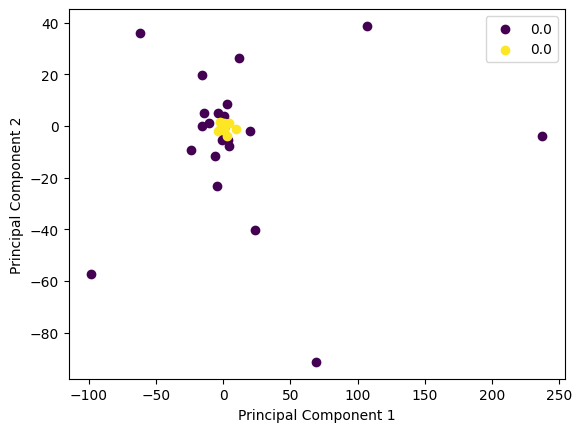

In [57]:
from __future__ import print_function
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np




def shuffle_data(X, y, seed=None):
    if seed:
        np.random.seed(seed)

    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)

    return X[idx], y[idx]



# 正规化数据集 X
def normalize(X, axis=-1, p=2):
    lp_norm = np.atleast_1d(np.linalg.norm(X, p, axis))
    lp_norm[lp_norm == 0] = 1
    return X / np.expand_dims(lp_norm, axis)


# 标准化数据集 X
def standardize(X):
    X_std = np.zeros(X.shape)
    mean = X.mean(axis=0)
    std = X.std(axis=0)

    # 做除法运算时请永远记住分母不能等于0的情形
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]

    return X_std


# 划分数据集为训练集和测试集
def train_test_split(X, y, test_size=0.2, shuffle=True, seed=None):
    if shuffle:
        X, y = shuffle_data(X, y, seed)

    n_train_samples = int(X.shape[0] * (1-test_size))
    x_train, x_test = X[:n_train_samples], X[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test



# 计算矩阵X的协方差矩阵
def calculate_covariance_matrix(X, Y=np.empty((0,0))):
    if not Y.any():
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)


# 计算数据集X每列的方差
def calculate_variance(X):
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - X.mean(axis=0)).T.dot(X - X.mean(axis=0)))
    return variance


# 计算数据集X每列的标准差
def calculate_std_dev(X):
    std_dev = np.sqrt(calculate_variance(X))
    return std_dev


# 计算相关系数矩阵
def calculate_correlation_matrix(X, Y=np.empty([0])):
    # 先计算协方差矩阵
    covariance_matrix = calculate_covariance_matrix(X, Y)
    # 计算X, Y的标准差
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance_matrix, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)



class PCA():
    """
    主成份分析算法PCA，非监督学习算法.
    """
    def __init__(self):
        self.eigen_values = None
        self.eigen_vectors = None
        self.k = 2

    def transform(self, X):
        """
        将原始数据集X通过PCA进行降维
        """
        covariance = calculate_covariance_matrix(X)

        # 求解特征值和特征向量
        self.eigen_values, self.eigen_vectors = np.linalg.eig(covariance)

        # 将特征值从大到小进行排序，注意特征向量是按列排的，即self.eigen_vectors第k列是self.eigen_values中第k个特征值对应的特征向量
        idx = self.eigen_values.argsort()[::-1]
        eigenvalues = self.eigen_values[idx][:self.k]
        eigenvectors = self.eigen_vectors[:, idx][:, :self.k]

        # 将原始数据集X映射到低维空间
        X_transformed = X.dot(eigenvectors)

        return X_transformed


def main():
    # Load the dataset
    X = data
    y = target

    # 将数据集X映射到低维空间
    X_trans = PCA().transform(X)

    x1 = X_trans[:, 0]
    x2 = X_trans[:, 1]

    cmap = plt.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

    class_distr = []
    # Plot the different class distributions
    for i, l in enumerate(np.unique(y)):
        _x1 = x1[y == l]
        _x2 = x2[y == l]
        _y = y[y == l]
        class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

    # Add a legend
    print(class_distr)
    plt.legend(class_distr, y, loc=1)

    # Axis labels
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()


if __name__ == "__main__":
    main()



[<matplotlib.collections.PathCollection object at 0x7f92b3f33340>, <matplotlib.collections.PathCollection object at 0x7f92b3f33730>]


/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


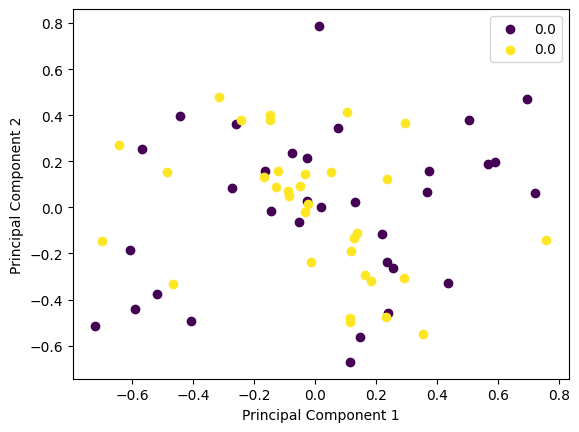

In [20]:
from __future__ import print_function
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np




def shuffle_data(X, y, seed=None):
    if seed:
        np.random.seed(seed)

    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)

    return X[idx], y[idx]



# 正规化数据集 X
def normalize(X, axis=-1, p=2):
    lp_norm = np.atleast_1d(np.linalg.norm(X, p, axis))
    lp_norm[lp_norm == 0] = 1
    return X / np.expand_dims(lp_norm, axis)


# 标准化数据集 X
def standardize(X):
    X_std = np.zeros(X.shape)
    mean = X.mean(axis=0)
    std = X.std(axis=0)

    # 做除法运算时请永远记住分母不能等于0的情形
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]

    return X_std


# 划分数据集为训练集和测试集
def train_test_split(X, y, test_size=0.2, shuffle=True, seed=None):
    if shuffle:
        X, y = shuffle_data(X, y, seed)

    n_train_samples = int(X.shape[0] * (1-test_size))
    x_train, x_test = X[:n_train_samples], X[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test



# 计算矩阵X的协方差矩阵
def calculate_covariance_matrix(X, Y=np.empty((0,0))):
    if not Y.any():
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)


# 计算数据集X每列的方差
def calculate_variance(X):
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - X.mean(axis=0)).T.dot(X - X.mean(axis=0)))
    return variance


# 计算数据集X每列的标准差
def calculate_std_dev(X):
    std_dev = np.sqrt(calculate_variance(X))
    return std_dev


# 计算相关系数矩阵
def calculate_correlation_matrix(X, Y=np.empty([0])):
    # 先计算协方差矩阵
    covariance_matrix = calculate_covariance_matrix(X, Y)
    # 计算X, Y的标准差
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance_matrix, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)



class PCA():
    """
    主成份分析算法PCA，非监督学习算法.
    """
    def __init__(self):
        self.eigen_values = None
        self.eigen_vectors = None
        self.k = 2

    def transform(self, X):
        """
        将原始数据集X通过PCA进行降维
        """
        covariance = calculate_covariance_matrix(X)

        # 求解特征值和特征向量
        self.eigen_values, self.eigen_vectors = np.linalg.eig(covariance)

        # 将特征值从大到小进行排序，注意特征向量是按列排的，即self.eigen_vectors第k列是self.eigen_values中第k个特征值对应的特征向量
        idx = self.eigen_values.argsort()[::-1]
        eigenvalues = self.eigen_values[idx][:self.k]
        eigenvectors = self.eigen_vectors[:, idx][:, :self.k]

        # 将原始数据集X映射到低维空间
        X_transformed = X.dot(eigenvectors)

        return X_transformed


def main():
    # Load the dataset
    X = data
    y = target

    # 将数据集X映射到低维空间
    X_trans = PCA().transform(X)

    x1 = X_trans[:, 0]
    x2 = X_trans[:, 1]

    cmap = plt.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

    class_distr = []
    # Plot the different class distributions
    for i, l in enumerate(np.unique(y)):
        _x1 = x1[y == l]
        _x2 = x2[y == l]
        _y = y[y == l]
        class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

    # Add a legend
    print(class_distr)
    plt.legend(class_distr, y, loc=1)

    # Axis labels
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()


if __name__ == "__main__":
    main()



In [18]:
w_high_bicubic = cv2.resize(w_low, dsize=(100,100), interpolation=cv2.INTER_CUBIC)

Text(0, 0.5, 'y')

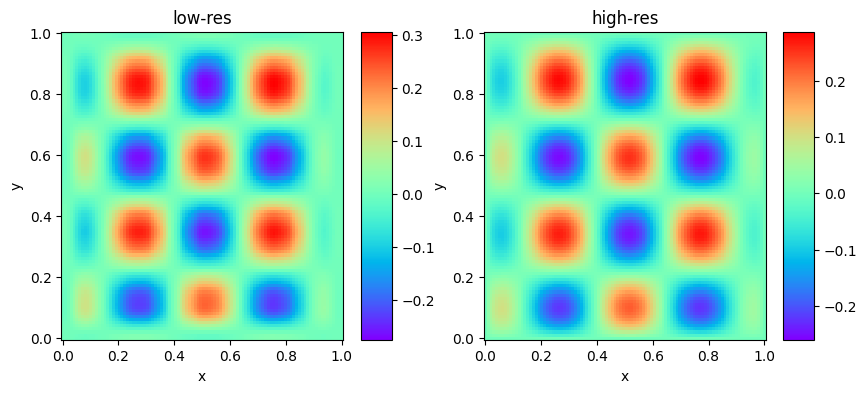

In [19]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_high,y_high, w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.xlabel('x')
plt.ylabel('y')
plt.title('low-res')
plt.subplot(1,2,2)
plt.pcolormesh(x_high,y_high,w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('high-res')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

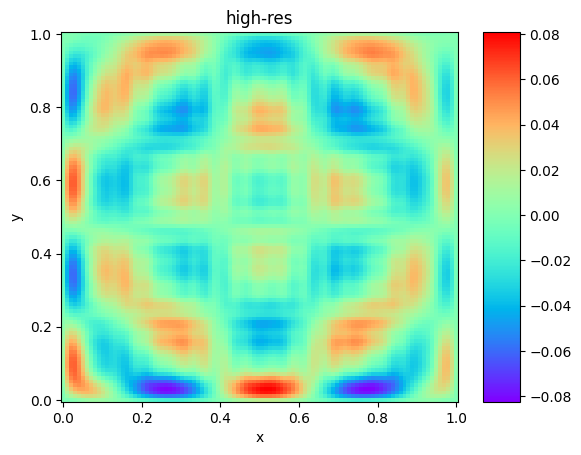

In [20]:
plt.pcolormesh(x_high,y_high,w_high-w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('high-res')
plt.xlabel('x')
plt.ylabel('y')

In [14]:
with h5py.File('high_res.h5', 'r') as hf:
    data = hf['high_res'][:]

In [15]:
trainset = torch.utils.data.DataLoader(dataset=data,batch_size=1,shuffle=False)